In [ ]:
import cv2
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import tensorflow as tf

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
import cv2
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

from IPython import display

In [ ]:
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [ ]:
img = '/content/drive/MyDrive/covid_gan/COVID/Covid (1).png'

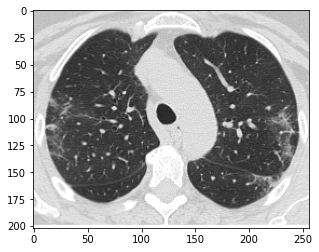

In [ ]:
img_colab = cv2.imread(img, cv2.IMREAD_UNCHANGED)
pyplot.imshow(img_colab)

In [ ]:
img_colab.shape

(202, 256, 3)

In [ ]:
im = cv2.resize(img_colab,(256,256))

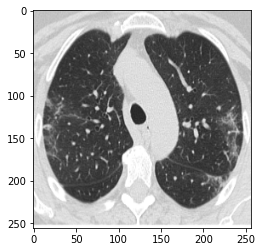

In [ ]:
pyplot.imshow(im)

In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/covid_gan/COVID"))

In [ ]:
dirr = "//content//drive/MyDrive//covid_gan//COVID//"
im_path = []
images = []
for i in os.listdir(dirr) :
  imagepath =  os.path.join(dirr, i)
  im_path.append(imagepath)
  print(imagepath)
  


In [ ]:
images = []
for i in im_path:
  img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
  img = cv2.resize(img,(64,64))
  images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
images

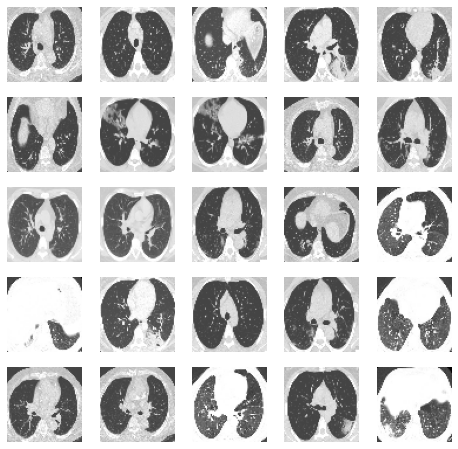

In [ ]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense , Flatten , Reshape , LeakyReLU , Dropout , UpSampling2D

In [ ]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

In [ ]:
!mkdir animeGenerated

mkdir: cannot create directory ‘animeGenerated’: File exists


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_103 (LeakyReLU)  (None, 64, 64, 128)      0         
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_104 (LeakyReLU)  (None, 64, 64, 128)      0         
                                                                 
 batch_normalization_25 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                    

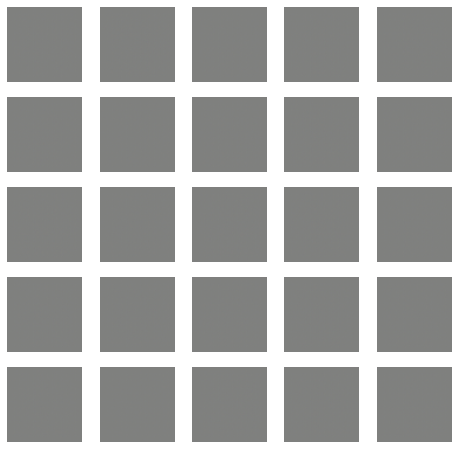

INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


200 [Discriminator loss: 0.563360, acc.: 73.13%] [Generator loss: 2.024297]
400 [Discriminator loss: 0.532657, acc.: 72.95%] [Generator loss: 2.112993]
600 [Discriminator loss: 0.492375, acc.: 75.74%] [Generator loss: 2.115549]
800 [Discriminator loss: 0.457604, acc.: 78.49%] [Generator loss: 2.117777]
1000 [Discriminator loss: 0.447496, acc.: 79.80%] [Generator loss: 2.094267]


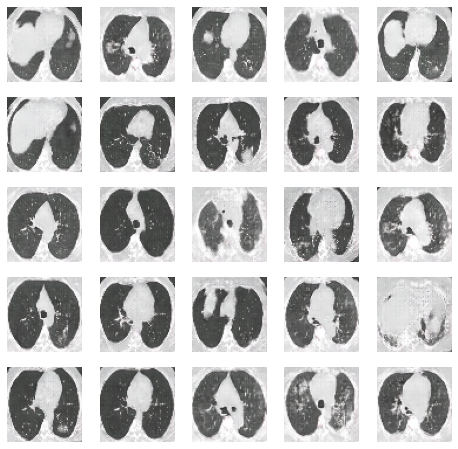

1200 [Discriminator loss: 0.385613, acc.: 83.66%] [Generator loss: 2.284896]
1400 [Discriminator loss: 0.354529, acc.: 85.38%] [Generator loss: 2.468326]
1600 [Discriminator loss: 0.307003, acc.: 88.04%] [Generator loss: 2.749548]
1800 [Discriminator loss: 0.276578, acc.: 89.33%] [Generator loss: 3.026212]
2000 [Discriminator loss: 0.239456, acc.: 91.13%] [Generator loss: 3.340802]


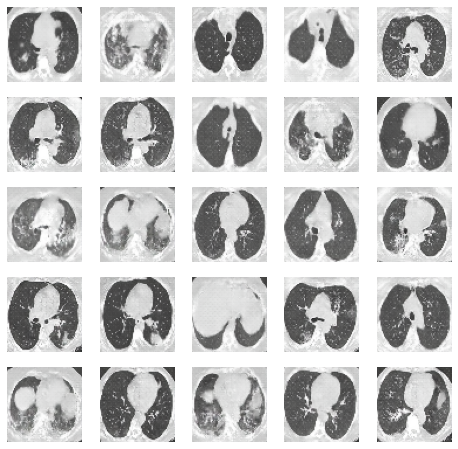

2200 [Discriminator loss: 0.222712, acc.: 91.63%] [Generator loss: 3.614943]
2400 [Discriminator loss: 0.188306, acc.: 93.25%] [Generator loss: 3.978894]
2600 [Discriminator loss: 0.175454, acc.: 93.68%] [Generator loss: 4.263820]
2800 [Discriminator loss: 0.240919, acc.: 91.25%] [Generator loss: 4.175336]
3000 [Discriminator loss: 0.134242, acc.: 95.48%] [Generator loss: 4.599305]


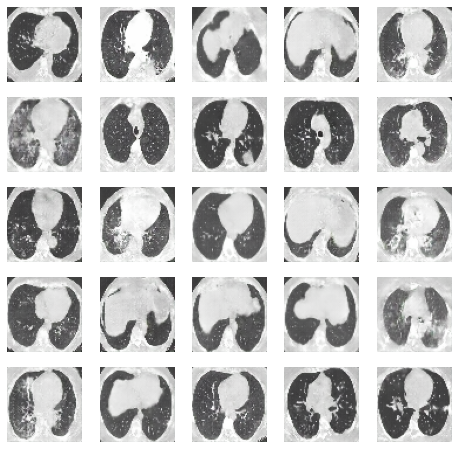

3200 [Discriminator loss: 0.123800, acc.: 95.80%] [Generator loss: 5.007890]
3400 [Discriminator loss: 0.128271, acc.: 95.51%] [Generator loss: 5.216772]
3600 [Discriminator loss: 0.122302, acc.: 95.75%] [Generator loss: 5.428185]
3800 [Discriminator loss: 0.201055, acc.: 92.96%] [Generator loss: 5.384316]
4000 [Discriminator loss: 0.123640, acc.: 95.73%] [Generator loss: 5.187007]


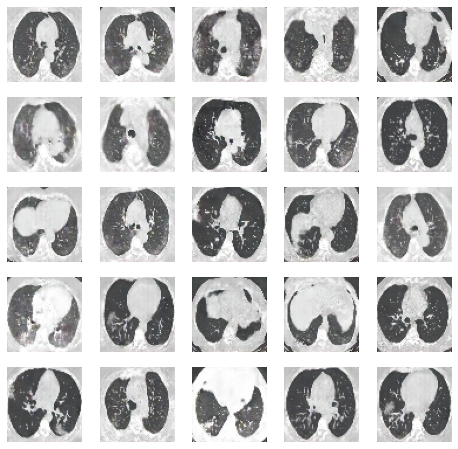

4200 [Discriminator loss: 0.093315, acc.: 96.91%] [Generator loss: 5.863967]
4400 [Discriminator loss: 0.093834, acc.: 96.84%] [Generator loss: 6.100361]
4600 [Discriminator loss: 0.093456, acc.: 96.73%] [Generator loss: 6.262553]
4800 [Discriminator loss: 0.091983, acc.: 96.79%] [Generator loss: 6.499677]
5000 [Discriminator loss: 0.328260, acc.: 90.68%] [Generator loss: 5.054552]


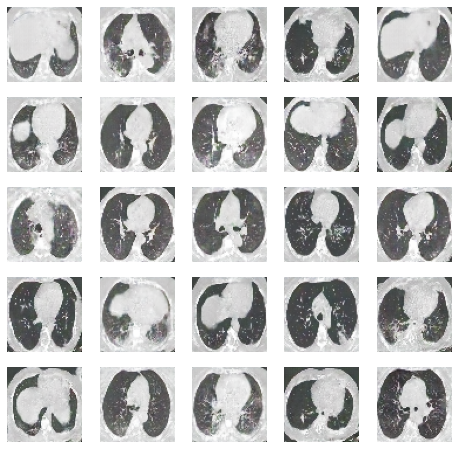

In [ ]:
gan=GAN()
gan.train(epochs=15001, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)